# Gene Expression and Experimental Conditions

Gene expression refers to the process by which information from a gene is used to synthesize a functional gene product, usually proteins, which play crucial roles in the structure, function, and regulation of the body's tissues and organs. In research, it's common to compare gene expression levels under different conditions to understand gene function, regulatory mechanisms, and potential therapeutic targets.

In the given context, two conditions are examined: control and treatment. The control condition represents the baseline or normal state of gene expression without any external intervention. The treatment condition involves altering the environment, typically through the application of a drug or genetic modification, to observe how gene expression changes in response.

# Gaussian Process

Gaussian Processes (GP) are a type of non-parametric model that is particularly useful for regression and classification in machine learning. They are favored for their flexibility and ability to model complex datasets without assuming a specific data distribution. A GP is defined by its mean function and a covariance function (kernel), which together describe the distribution of functions fitting the data.

Mathematically, a GP is expressed as:

f(x)∼GP(m(x),k(x,x′))

The RBF is: 

k(x,x′)=σ^2exp(−(∥x−x′∥^2)/2l^2)

σ^2 is the variance.

l is the length scale of the kernel.

# Covariance

Covariance is the kernel used so ours is the Squared Exponential (RBF) Kernel:

k(x,x′)=σ^2exp(−(∥x−x′∥^2)/2l^2)

σ^2 is the variance.

l is the length scale of the kernel.

# Gaussian Process as Linear Regeression

Gaussian Processes (GPs) can be thought of as a generalization of linear regression models, providing a flexible framework for regression problems. In linear regression, the goal is to fit a linear model to the data, often with assumptions about the normality of errors. GP regression, on the other hand, extends this idea by placing a Gaussian process prior over functions. This allows for modeling not just linear relationships but any form of relationship that can be captured by the chosen kernel (covariance function).

The key to understanding how GP can serve as linear regression lies in the choice of the kernel. A linear kernel, for example, would result in GP regression behaving similarly to traditional linear regression. The RBF kernel used in the code, which stands for Radial Basis Function, is a popular choice for its flexibility and ability to model smooth, non-linear relationships between the independent and dependent variables.

# Predictions with Gaussian Process

The essence of making predictions with a GP model involves:

Choosing a Kernel: The kernel defines the covariance function of the GP. It encodes assumptions about the function you wish to learn. The RBF kernel is a good default choice.
Training: This involves fitting the GP model to the data, which in practice means computing the kernel matrix (covariance) for the training data and finding the parameters (e.g., length scale in RBF) that maximize the likelihood of the observed data.
Predicting: For new input points, the GP model uses the kernel function to compute the covariance between the new points and the training points, and between the new points themselves. It then uses these covariances and the observations from the training data to form a predictive distribution for each new point. This distribution is Gaussian, characterized by a mean (the prediction) and a variance (the uncertainty of the prediction).

# Gaussian Process Prior

When talked about a GP prior in the context of regression, this is referring to a prior distribution over functions. This prior is characterized by two main components:

Mean Function (m(x)): This function represents the average or expected value of the function at any point x. In many practical GP applications, including the example provided, the mean function is often assumed to be zero or another constant value for simplicity, unless there is a strong reason to choose otherwise.

Covariance Function (Kernel) (k(x,x')): The covariance function defines how the function values at two different points x and x' in the input space are related to each other. It essentially describes the "shape" of functions that the GP models.

The GP prior, combined with observed data, is used to compute the posterior distribution over functions. This posterior represents our updated belief about the function after seeing the data. It is from this posterior that we make predictions for new input points.



# Address posterior noise-free observations and predictions with noisy observations.


 This process involves computing the GP posterior and using it for making predictions.

 The GP posterior distribution represents our updated belief about the function after observing data. It's derived by applying Bayes' theorem, combining the GP prior and the likelihood of the observed data. The posterior gives us a distribution over possible functions that are consistent with both our prior assumptions and the observed data.

 This distribution is Gaussian, with a mean and covariance that can be calculated based on the prior mean and covariance functions, the observed data, and the noise level in the observations.

 Noise-free Predictions: If we assume our observations are noise-free, the predictions are made directly using the posterior mean and covariance. This scenario might be less common in practice, especially in biological data, where measurement noise is inevitable.

Predictions with Noisy Observations: More commonly, we acknowledge that our observations include noise. This is incorporated into the model by adjusting the covariance function to include a noise term. Predictions then account for both the uncertainty in the function and the noise in the observations. This results in slightly wider confidence intervals around predictions.


# Gaussian Process Model 

###  Create Synthetic Data

First we start by generating synthetic data that describes a situation where the control group and treatment group have similar expression levels, up until some treatment effect is introduced to the treatment group. The introduction of a treatment effect can be observed as a change point in the graph below marking a change in the treatment group.

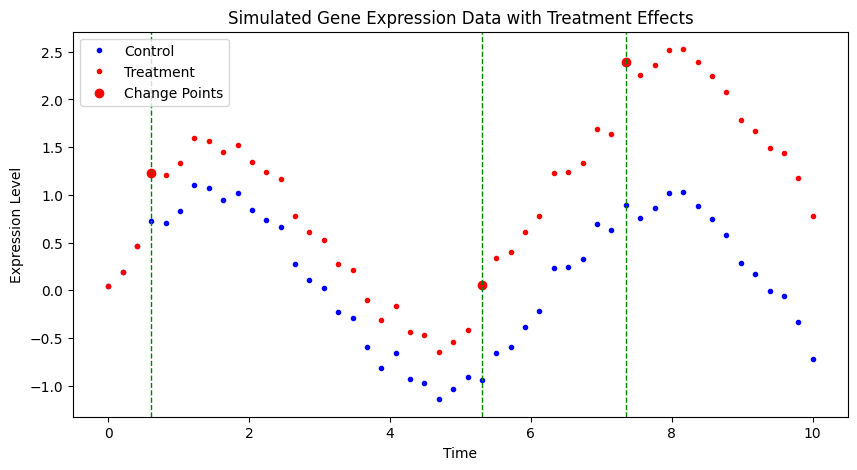

In [22]:
import numpy as np
import matplotlib.pyplot as plt

# Simulating time series data for gene expression
np.random.seed(42)  # For reproducibility
time_points = np.linspace(0, 10, 50)  # Time points

# Simulating control condition
true_function_control = lambda X: np.sin(X)
y_control = true_function_control(time_points) + np.random.normal(0, 0.1, size=len(time_points))

# Creating treatment condition based on control
y_treatment = np.copy(y_control)

# Introducing differences in treatment condition
num_changes = 3  # Number of changes to introduce
change_points = np.random.choice(len(time_points), num_changes, replace=False)  # Randomly select change points
change_magnitude = 0.5  # Magnitude of change introduced
for point in change_points:
    y_treatment[point:] += change_magnitude  # Add a constant difference from this point onwards

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(time_points, y_control, 'b.', label='Control')  # Plot control condition points
plt.plot(time_points, y_treatment, 'r.', label='Treatment')  # Plot treatment condition points
plt.scatter(time_points[change_points], y_treatment[change_points], c='red', label='Change Points', marker='o')  # Scatter plot for change points

# Adding vertical lines at change points
for point in change_points:
    plt.axvline(x=time_points[point], color='green', linestyle='--', linewidth=1)

plt.legend()
plt.title('Simulated Gene Expression Data with Treatment Effects')
plt.xlabel('Time')
plt.ylabel('Expression Level')
plt.show()


### Parameter Optimization

In order to optimize the models we can use grid search which allows us to create models with every combination of parameters defined in our grid and determine which paramaters result in the best performance based on the loss of each model. This allows us to systematically try different combinations and find the paramaters that yield the best performance.

In [41]:
from sklearn.model_selection import GridSearchCV
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

def find_best_gp_model(X, y):
    # Define the parameter grid to search
    param_grid = {
        'kernel': [RBF(length_scale=length_scale) for length_scale in [0.1, 1.0, 10.0]],
        'alpha': [0.1, 0.01, 0.001],
        'n_restarts_optimizer': [5, 10, 15]
    }
    
    # Create Gaussian Process Regressor
    gp = GaussianProcessRegressor()
    
    # Perform grid search
    grid_search = GridSearchCV(gp, param_grid, scoring='neg_mean_squared_error', cv=5)
    grid_search.fit(X, y)
    
    # Print the best parameters
    print("Best Parameters:", grid_search.best_params_)
    
    # Return the best model
    return grid_search.best_estimator_


### Train Control Group and Treatment Group Models

Once we've generated our control and treatment group data, we can now fit a GP model to the data to enable predicting. To create the model we used the sklearn library and fed our data through, it was as simple as creating an instance of the model and then calling the function. In terms of predictions, we predicted the values in between each time point that was generated previously which allows us to see all the changes in the gene expression over time. The process was repeated twice, once for the control group and again for the treatment group.

C:\Users\Mario\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\Mario\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\Mario\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Best Parameters: {'alpha': 0.1, 'kernel': RBF(length_scale=0.1), 'n_restarts_optimizer': 5}


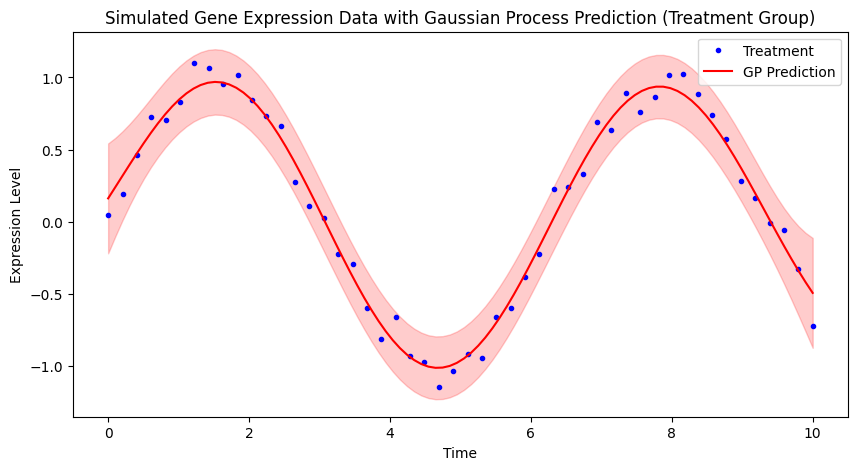

In [57]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

# Define the kernel
kernel = RBF(length_scale=1.0)

# Find the best Gaussian Process model for the treatment group
best_gp_model = find_best_gp_model(time_points[:, np.newaxis], y_control)

# Make predictions for new time points
time_points_new = np.linspace(0, 10, 100)
y_control_pred, sigma = best_gp_model.predict(time_points_new[:, np.newaxis], return_std=True)

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(time_points, y_control, 'b.', label='Treatment')  # Plot treatment condition points

# Plot GP predictions for the treatment condition
plt.plot(time_points_new, y_control_pred, 'r-', label='GP Prediction')  # Change line color to green
plt.fill_between(time_points_new, y_control_pred - 2 * sigma, y_control_pred + 2 * sigma, alpha=0.2, color='red')  # Change shading color to green

plt.legend()
plt.title('Simulated Gene Expression Data with Gaussian Process Prediction (Treatment Group)')
plt.xlabel('Time')
plt.ylabel('Expression Level')
plt.show()


C:\Users\Mario\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\Mario\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\Mario\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\M

Best Parameters: {'alpha': 0.1, 'kernel': RBF(length_scale=1), 'n_restarts_optimizer': 5}


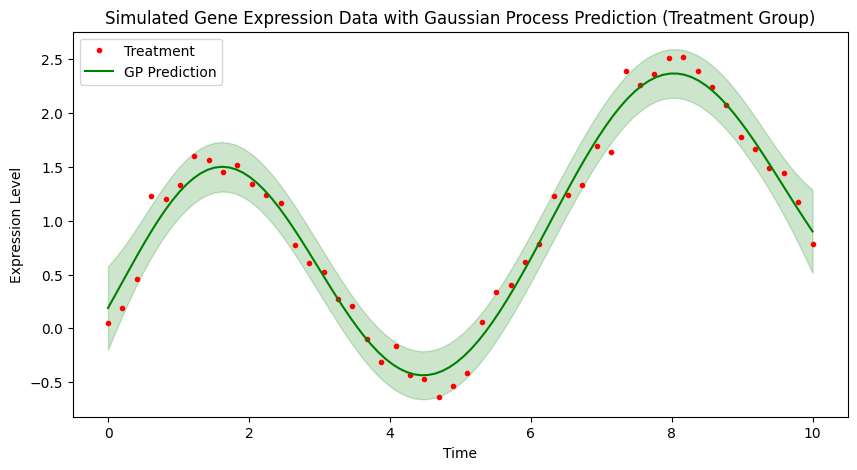

In [60]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

# Define the kernel
kernel = RBF(length_scale=1.0)

# Find the best Gaussian Process model for the treatment group
best_gp_model = find_best_gp_model(time_points[:, np.newaxis], y_treatment)

# Make predictions for new time points
time_points_new = np.linspace(0, 10, 100)
y_treatment_pred, sigma = best_gp_model.predict(time_points_new[:, np.newaxis], return_std=True)

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(time_points, y_treatment, 'r.', label='Treatment')  # Plot treatment condition points

# Plot GP predictions for the treatment condition
plt.plot(time_points_new, y_treatment_pred, 'g-', label='GP Prediction')  # Change line color to green
plt.fill_between(time_points_new, y_treatment_pred - 2 * sigma, y_treatment_pred + 2 * sigma, alpha=0.2, color='green')  # Change shading color to green

plt.legend()
plt.title('Simulated Gene Expression Data with Gaussian Process Prediction (Treatment Group)')
plt.xlabel('Time')
plt.ylabel('Expression Level')
plt.show()


### Testing for Differential Expression

#### Through Visualization

To test for differential expression we could start by visualizing the two groups over each other, in this case the expressions are different enough that it's clear that there is differential expression. In other cases the difference may not be so obvious so it's essential to test for differential expression through other means as well.

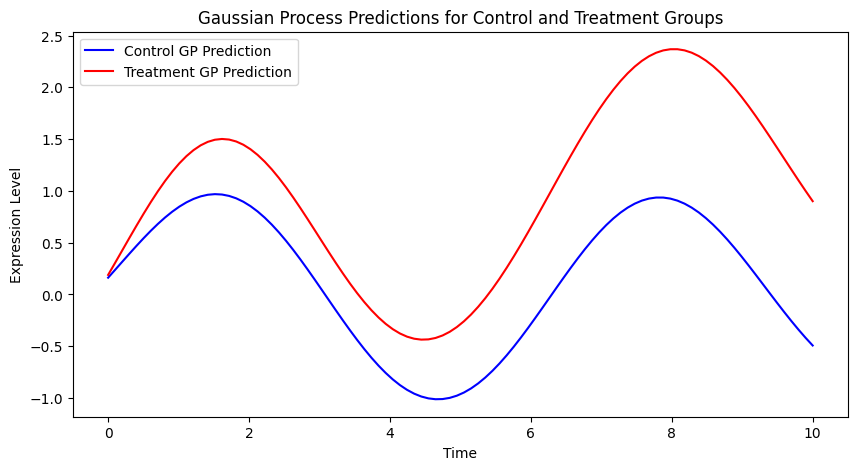

In [62]:
# Plotting expressions of both control and treatment groups together
plt.figure(figsize=(10, 5))

# Plot GP predictions for control group
plt.plot(time_points_new, y_control_pred, 'b-', label='Control GP Prediction')

# Plot GP predictions for treatment group
plt.plot(time_points_new, y_treatment_pred, 'r-', label='Treatment GP Prediction')

plt.legend()
plt.title('Gaussian Process Predictions for Control and Treatment Groups')
plt.xlabel('Time')
plt.ylabel('Expression Level')
plt.show()


#### Calculating Difference

Another option is calculate the difference in expression level at each time interval for both groups. This allows us to see how significant each difference is at each time interval which gives insight to the difference between the two expressions. Of course, it's important to note that this is based on the predicted values provided by the GP model so there is a possibility of error. This also allows us to see the standard deviation of the differences which gives context to the differences calculated by telling us what differences are considered normal/insignificant. 

In [63]:
# Predict expression levels for control and treatment groups
y_control_pred = gp_control.predict(time_points.reshape(-1, 1))
y_treatment_pred = gp_treatment.predict(time_points.reshape(-1, 1))

# Calculate differences
differences = y_treatment_pred - y_control_pred

# Optionally, calculate standard deviation for differences
# You can use the standard deviation of the predicted expression levels or compute it separately
# For simplicity, let's assume we have it already
std_control = np.std(y_control_pred)
std_treatment = np.std(y_treatment_pred)
std_differences = np.sqrt(std_control**2 + std_treatment**2)  # Assuming independence

# Print or analyze the differences
print("Differences in expression levels:")
print(differences)

# Print or analyze the standard deviation of differences
print("Standard deviation of differences:")
print(std_differences)


Differences in expression levels:
[-2.55487298e-11  8.21759527e-02 -9.44627567e-02  1.20447595e-02
 -1.61113972e-02 -2.83264767e-02 -1.02131715e-01  2.57490290e-01
  4.45541688e-01  2.98427602e-01  6.80308959e-01  5.43356694e-01
  4.75863310e-01  6.01748267e-01  5.63921492e-01  1.11131973e+00
  1.00127466e+00  9.82203805e-01  1.07828709e+00  1.09900990e+00
  9.28180816e-01  1.02904130e+00  8.66792119e-01  1.14643461e+00
  9.32042437e-01  1.02442798e+00  1.11142133e+00  1.02581495e+00
  1.55425917e+00  1.64646217e+00  1.52959697e+00  1.17202556e+00
  1.66834131e+00  1.67401466e+00  1.38218023e+00  1.80590186e+00
  1.64896453e+00  1.65506160e+00  1.55071163e+00  1.28309513e+00
  1.44481735e+00  1.46733537e+00  1.45603125e+00  1.58882327e+00
  1.69912473e+00  1.66909414e+00  1.50386674e+00  1.24518507e+00
  1.49352799e+00  1.65284530e+00]
Standard deviation of differences:
1.043150927748438


#### T-Test

The last method we used to test for differential expression is the t-test which tells us whether the observed differences in expression levels between the control and treatment groups are statistically significant.

In [69]:
from scipy.stats import ttest_ind

# Perform t-test
t_statistic, p_value = ttest_ind(y_control_pred, y_treatment_pred)

# Check significance
if p_value < 0.05:
    print("Differential expression detected (p < 0.05)")
else:
    print("No significant differential expression")

Differential expression detected (p < 0.05)


# Analysis

Overall, we used synthetic data to model a situation where the gene expression of a control and treatment group are identical up to the point where the treatment group is modified. Fitting GP models on this data allowed us to see a fuller picture of how the expression levels changed overtime by predicting the values in between the predefined time intervals. We also showed how we could use these predictions to determine whether there exists differential expression in the two groups. In a real world scenario this would allow experts to better track how the changes they make to the treatment group impact the gene expression.